In [1]:
import pandas as pd

train_df = pd.read_csv('data/subset_train_expanded.csv')
valid_df = pd.read_csv('data/subset_valid_expanded.csv')
test_df = pd.read_csv('data/subset_test_expanded.csv')

In [2]:
from structs import PMDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np

INPUT_VARS = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

def pre_format(df: 'pd.DataFrame', scaler: 'MinMaxScaler' = None) -> 'Tuple[np.array, np.array, MinMaxScaler]':

    input_samples = np.empty((len(INPUT_VARS), len(df)))
    for idx, var in enumerate(INPUT_VARS):
        input_samples[idx] = df[var].to_numpy()
    input_samples = np.transpose(input_samples)
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(input_samples)
    input_samples = scaler.transform(input_samples)
    input_samples = np.nan_to_num(input_samples)

    target_samples = np.zeros((len(df), 2))
    for idx, _tar in enumerate(df['Machine failure'].to_numpy()):
        if _tar == 0:
            target_samples[idx][0] = 1.0
        else:
            target_samples[idx][1] = 1.0

    return (input_samples, target_samples, scaler)

X_train, y_train, scaler = pre_format(train_df)
X_valid, y_valid, _ = pre_format(valid_df, scaler)
X_test, y_test, _ = pre_format(test_df, scaler)

dataset_train = PMDataset(X_train, y_train)
dataset_valid = PMDataset(X_valid, y_valid)
dataset_test = PMDataset(X_test, y_test)

In [3]:
# Train model, NO hyper-parameter tuning (baseline)

from structs import SoftmaxMLP, train_model_validate

model = SoftmaxMLP(dataset_train.X.shape[1], 32, dataset_train.y.shape[1])
trained_model, train_loss, valid_loss = train_model_validate(
    model, dataset_train, dataset_valid,
    epochs=150, batch_size=8, patience=8,
    verbose=10, lr=0.001
)

Epoch: 0 | Training loss: 0.04679115591908839 | Validation loss: 7.39796621511217e-05
Epoch: 10 | Training loss: 0.026746053242223317 | Validation loss: 6.065035971706031e-05
Epoch: 20 | Training loss: 0.02315646059197064 | Validation loss: 7.522550457325138e-05
Epoch: 30 | Training loss: 0.02093643790171053 | Validation loss: 5.72050081901863e-05


<Figure size 432x288 with 0 Axes>

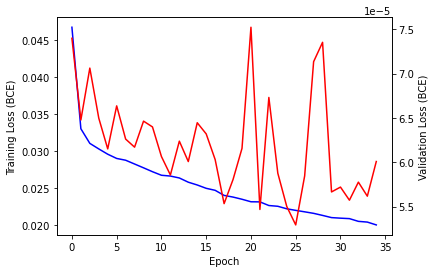

In [4]:
from matplotlib import pyplot as plt

epochs = [i for i in range(len(train_loss))]
plt.clf()
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, color='blue', label='Training loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss (BCE)')
ax2 = ax.twinx()
ax2.plot(epochs, valid_loss, color='red', label='Validation loss')
ax2.set_ylabel('Validation Loss (BCE)')
plt.show()

In [5]:
y_train_hat = model(dataset_train.X).detach().numpy()
_temp = np.zeros_like(y_train_hat)
_temp[np.arange(len(y_train_hat)), y_train_hat.argmax(1)] = 1
y_train_hat = [np.where(r==1)[0][0] for r in _temp]

y_train = dataset_train.y.detach().numpy()
y_train = [np.where(r==1)[0][0] for r in y_train]

<Figure size 432x288 with 0 Axes>

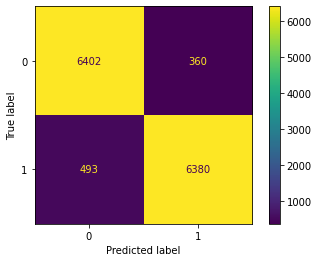

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

plt.clf()
cm = confusion_matrix(y_train, y_train_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [7]:
y_valid_hat = model(dataset_valid.X).detach().numpy()
_temp = np.zeros_like(y_valid_hat)
_temp[np.arange(len(y_valid_hat)), y_valid_hat.argmax(1)] = 1
y_valid_hat = [np.where(r==1)[0][0] for r in _temp]

y_valid = dataset_valid.y.detach().numpy()
y_valid = [np.where(r==1)[0][0] for r in y_valid]

<Figure size 432x288 with 0 Axes>

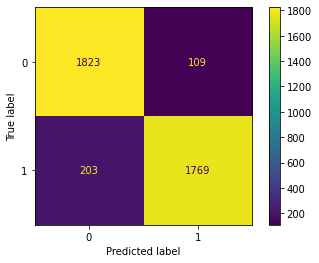

In [8]:
plt.clf()
cm = confusion_matrix(y_valid, y_valid_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [9]:
y_test_hat = model(dataset_test.X).detach().numpy()
_temp = np.zeros_like(y_test_hat)
_temp[np.arange(len(y_test_hat)), y_test_hat.argmax(1)] = 1
y_test_hat = [np.where(r==1)[0][0] for r in _temp]

y_test = dataset_test.y.detach().numpy()
y_test = [np.where(r==1)[0][0] for r in y_test]

<Figure size 432x288 with 0 Axes>

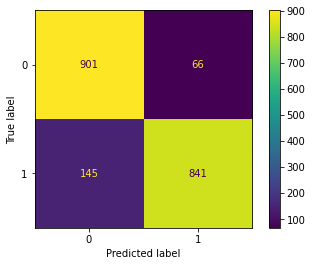

In [10]:
plt.clf()
cm = confusion_matrix(y_test, y_test_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [11]:
print(classification_report(y_train, y_train_hat))
print(classification_report(y_valid, y_valid_hat))
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6762
           1       0.95      0.93      0.94      6873

    accuracy                           0.94     13635
   macro avg       0.94      0.94      0.94     13635
weighted avg       0.94      0.94      0.94     13635

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1932
           1       0.94      0.90      0.92      1972

    accuracy                           0.92      3904
   macro avg       0.92      0.92      0.92      3904
weighted avg       0.92      0.92      0.92      3904

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       967
           1       0.93      0.85      0.89       986

    accuracy                           0.89      1953
   macro avg       0.89      0.89      0.89      1953
weighted avg       0.89      0.89      0.89      1953



In [12]:
import torch.nn as nn
import torch

def fitness_function(hparams: 'List[float]') -> float:

    hidden_size = hparams[0]
    batch_size = hparams[1]
    lr = hparams[2]

    test_loss = []

    for _ in range(5):

        _model = SoftmaxMLP(dataset_train.X.shape[1], hidden_size, dataset_train.y.shape[1])
        _tr_model, _, _ = train_model_validate(
            _model, dataset_train, dataset_valid,
            epochs=50, batch_size=batch_size, patience=16,
            lr=lr
        )

        _y_test_hat = _tr_model(dataset_test.X).detach().numpy()
        _temp = np.zeros_like(_y_test_hat)
        _temp[np.arange(len(_y_test_hat)), _y_test_hat.argmax(1)] = 1
        _y_test_hat = [np.where(r==1)[0][0] for r in _temp]
        _y_test = dataset_test.y.detach().numpy()
        _y_test = [np.where(r==1)[0][0] for r in _y_test]

        _y_test_hat = torch.as_tensor(_y_test_hat).type(torch.float64)
        _y_test = torch.as_tensor(_y_test).type(torch.float64)

        _loss = nn.BCELoss()
        test_loss.append(_loss(_y_test_hat, _y_test).detach().numpy())

    return np.mean(test_loss)

In [13]:
from ecabc import ABC
from time import time

abc = ABC(5, fitness_function)

abc.add_param(5, 64, restrict=True)             # size of hidden layers
abc.add_param(8, 128, restrict=True)            # batch size
abc.add_param(1e-6, 0.005, restrict=True)         # learning rate

abc.initialize()

ave_fitness = []
ave_ret_val = []
best_fitness = []
best_ret_val = []
best_params = []
for i in range(5):
    abc.search()
    print(f'Iteration: {i + 1} | {time()}')
    ave_fitness.append(abc.average_fitness)
    ave_ret_val.append(abc.average_ret_val)
    best_fitness.append(abc.best_fitness)
    best_ret_val.append(abc.best_ret_val)
    best_params.append(abc.best_params)

best_param_vals = abc.best_params

Iteration: 1 | 1637682546.90654
Iteration: 2 | 1637683019.948847
Iteration: 3 | 1637683408.6478631
Iteration: 4 | 1637683793.784804
Iteration: 5 | 1637684287.418323


<Figure size 432x288 with 0 Axes>

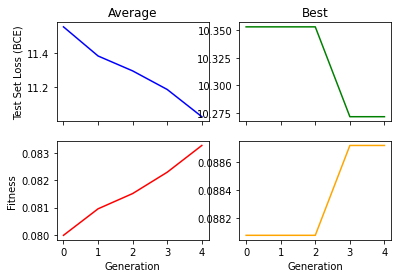

In [14]:
generation = [i for i in range(len(ave_fitness))]

plt.clf()
fig, axs = plt.subplots(2, 2, sharex='col')
axs[1, 0].set_xlabel('Generation')
axs[1, 1].set_xlabel('Generation')
axs[0, 0].set_ylabel('Test Set Loss (BCE)')
axs[1, 0].set_ylabel('Fitness')
axs[0, 0].set_title('Average')
axs[0, 1].set_title('Best')

axs[0, 0].plot(generation, ave_ret_val, color='blue')
axs[0, 1].plot(generation, best_ret_val, color='green')
axs[1, 0].plot(generation, ave_fitness, color='red')
axs[1, 1].plot(generation, best_fitness, color='orange')

plt.show()

In [15]:
hidden_size = best_param_vals['P0']
batch_size = best_param_vals['P1']
learning_rate = best_param_vals['P2']

print(best_param_vals)


{'P0': 31, 'P1': 111, 'P2': 0.004370567548158755}


In [16]:
model = SoftmaxMLP(dataset_train.X.shape[1], hidden_size, dataset_train.y.shape[1])
trained_model, train_loss, valid_loss = train_model_validate(
    model, dataset_train, dataset_valid, verbose=10,
    epochs=100, batch_size=batch_size, patience=16,
    lr=learning_rate
)

Epoch: 0 | Training loss: 0.004498849087335008 | Validation loss: 8.021004223188416e-05
Epoch: 10 | Training loss: 0.001995059277904659 | Validation loss: 7.413818546738781e-05
Epoch: 20 | Training loss: 0.0018953924355902077 | Validation loss: 6.477376751479556e-05
Epoch: 30 | Training loss: 0.0015906871539968512 | Validation loss: 5.8354905302651594e-05
Epoch: 40 | Training loss: 0.001379035718173477 | Validation loss: 6.558902592199747e-05
Epoch: 50 | Training loss: 0.0012216008095829575 | Validation loss: 6.381319606768304e-05


<Figure size 432x288 with 0 Axes>

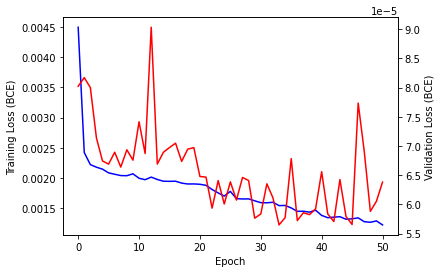

In [17]:
epochs = [i for i in range(len(train_loss))]
plt.clf()
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, color='blue', label='Training loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss (BCE)')
ax2 = ax.twinx()
ax2.plot(epochs, valid_loss, color='red', label='Validation loss')
ax2.set_ylabel('Validation Loss (BCE)')
plt.show()

In [18]:
y_train_hat = trained_model(dataset_train.X).detach().numpy()
_temp = np.zeros_like(y_train_hat)
_temp[np.arange(len(y_train_hat)), y_train_hat.argmax(1)] = 1
y_train_hat = [np.where(r==1)[0][0] for r in _temp]

y_train = dataset_train.y.detach().numpy()
y_train = [np.where(r==1)[0][0] for r in y_train]

<Figure size 432x288 with 0 Axes>

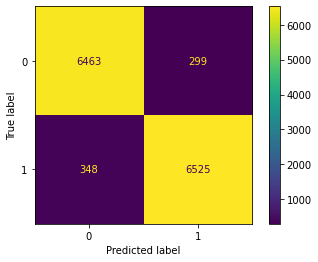

In [19]:
plt.clf()
cm = confusion_matrix(y_train, y_train_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [20]:
y_valid_hat = model(dataset_valid.X).detach().numpy()
_temp = np.zeros_like(y_valid_hat)
_temp[np.arange(len(y_valid_hat)), y_valid_hat.argmax(1)] = 1
y_valid_hat = [np.where(r==1)[0][0] for r in _temp]

y_valid = dataset_valid.y.detach().numpy()
y_valid = [np.where(r==1)[0][0] for r in y_valid]

<Figure size 432x288 with 0 Axes>

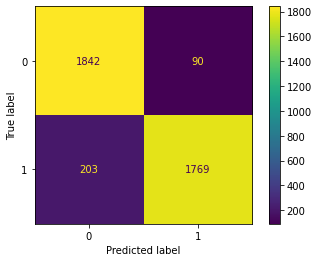

In [21]:
plt.clf()
cm = confusion_matrix(y_valid, y_valid_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [22]:
y_test_hat = model(dataset_test.X).detach().numpy()
_temp = np.zeros_like(y_test_hat)
_temp[np.arange(len(y_test_hat)), y_test_hat.argmax(1)] = 1
y_test_hat = [np.where(r==1)[0][0] for r in _temp]

y_test = dataset_test.y.detach().numpy()
y_test = [np.where(r==1)[0][0] for r in y_test]

<Figure size 432x288 with 0 Axes>

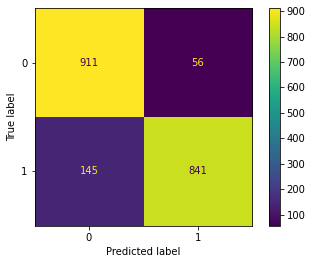

In [23]:
plt.clf()
cm = confusion_matrix(y_test, y_test_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [24]:
print(classification_report(y_train, y_train_hat))
print(classification_report(y_valid, y_valid_hat))
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6762
           1       0.96      0.95      0.95      6873

    accuracy                           0.95     13635
   macro avg       0.95      0.95      0.95     13635
weighted avg       0.95      0.95      0.95     13635

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1932
           1       0.95      0.90      0.92      1972

    accuracy                           0.92      3904
   macro avg       0.93      0.93      0.92      3904
weighted avg       0.93      0.92      0.92      3904

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       967
           1       0.94      0.85      0.89       986

    accuracy                           0.90      1953
   macro avg       0.90      0.90      0.90      1953
weighted avg       0.90      0.90      0.90      1953

